In [2]:
import polars as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
from pathlib import Path
import gc
from tqdm import tqdm
import math
from lightgbm import LGBMRegressor, plot_importance
from sklearn.metrics import r2_score
from prj.config import DATA_DIR
from prj.data.data_loader import DataConfig, DataLoader

In [3]:
def evaluate_model(model, X_train, y_train, X_val, y_val, weights, feature_names):   
    model.fit(X_train, y_train, feature_name=feature_names)
    pred_val = model.predict(X_val).clip(-5, 5)
    return r2_score(y_val, pred_val, sample_weight=weights)

In [4]:
def build_splits(df: pl.LazyFrame, features):
    X = df.select(features).cast(pl.Float32).collect().to_numpy()
    y = df.select('responder_6').cast(pl.Float32).collect().to_series().to_numpy()
    w = df.select('weight').cast(pl.Float32).collect().to_series().to_numpy()
    return X, y, w

In [5]:
from prj.data.data_loader import PARTITIONS_DATE_INFO


data_args = {}
config = DataConfig(**data_args)
loader = DataLoader(data_dir=DATA_DIR, config=config)
start_dt, end_dt = PARTITIONS_DATE_INFO[8]['min_date'], PARTITIONS_DATE_INFO[9]['max_date']

complete_ds = loader.load(start_dt=start_dt, end_dt=end_dt)
features = loader.features

start_val_date = PARTITIONS_DATE_INFO[9]['min_date']

In [6]:
params = {'n_estimators': 200, 'max_depth': 3, 'num_leaves': 8, 'learning_rate': 5e-2}

In [6]:
model = LGBMRegressor(**params)
train_ds = complete_ds.filter(pl.col('date_id') < start_val_date)
val_ds = complete_ds.filter(pl.col('date_id') >= start_val_date)

X_train, y_train, w_train = build_splits(train_ds, features=features)
X_val, y_val, w_val = build_splits(val_ds, features=features)

evaluate_model(model, X_train, y_train, X_val, y_val, w_val, features)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
plot_importance(model, importance_type='gain', title='Feature importance (Gain)', ax=ax)

In [ ]:
del X_train, y_train, w_train, X_val, y_val, w_val, model
gc.collect()

In [15]:
data_args = {'include_time_id': True}
config = DataConfig(**data_args)
loader = DataLoader(data_dir=DATA_DIR, config=config)
start_dt, end_dt = PARTITIONS_DATE_INFO[8]['min_date'], PARTITIONS_DATE_INFO[9]['max_date']

complete_ds = loader.load(start_dt=start_dt, end_dt=end_dt)

# complete_ds = complete_ds.with_columns(
#     pl.col('time_id').truediv(
#         pl.col('time_id').max().over('date_id', 'symbol_id')
#     )
# )
# features = loader.features
# start_val_date = PARTITIONS_DATE_INFO[9]['min_date']

# model = LGBMRegressor(**params)
# train_ds = complete_ds.filter(pl.col('date_id') < start_val_date)
# val_ds = complete_ds.filter(pl.col('date_id') >= start_val_date)

# X_train, y_train, w_train = build_splits(train_ds, features=features)
# X_val, y_val, w_val = build_splits(val_ds, features=features)

# evaluate_model(model, X_train, y_train, X_val, y_val, w_val, features)

In [ ]:
#0.005293672822496265

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
plot_importance(model, importance_type='gain', title='Feature importance (Gain)', ax=ax)

# Aggregations

In [33]:
MEAN_FEATURES = [0, 2, 3, 5, 6, 7, 18, 19, 34, 35, 36, 37, 38, 41, 43, 44, 48, 53, 55, 59, 62, 65, 68, 73, 74, 75, 76, 77, 78]
STD_FEATURES = [39, 42, 46, 53, 57, 66]
SKEW_FEATURES = [5, 40, 41, 42, 43, 44]
ZSCORE_FEATURES = [1, 36, 40, 45, 48, 49, 51, 52, 53, 54, 55, 59, 60]
def _include_intrastock_norm(df: pl.LazyFrame) -> pl.LazyFrame:
    df = df.with_columns(
        pl.col([f'feature_{j:02d}' for j in set(MEAN_FEATURES + ZSCORE_FEATURES)]).mean().over(['date_id', 'time_id']).name.suffix('_mean'),
        pl.col([f'feature_{j:02d}' for j in set(STD_FEATURES + ZSCORE_FEATURES)]).std().over(['date_id', 'time_id']).name.suffix('_std'),
        pl.col([f'feature_{j:02d}' for j in SKEW_FEATURES]).skew().over(['date_id', 'time_id']).name.suffix('_skew'),
    ).with_columns(
        pl.col(f'feature_{j:02d}').sub(f'feature_{j:02d}_mean').truediv(f'feature_{j:02d}_std').name.suffix('_zscore') for j in ZSCORE_FEATURES
    ).drop([f'feature_{j:02d}_std' for j in ZSCORE_FEATURES if j not in STD_FEATURES] + \
        [f'feature_{j:02d}_mean' for j in ZSCORE_FEATURES if j not in MEAN_FEATURES]
    )
    
    return df

In [34]:
data_args = {'include_time_id': True}
config = DataConfig(**data_args)
loader = DataLoader(data_dir=DATA_DIR, config=config)
start_dt, end_dt = PARTITIONS_DATE_INFO[8]['min_date'], PARTITIONS_DATE_INFO[9]['max_date']

complete_ds = loader.load(start_dt=start_dt, end_dt=end_dt)
features = loader.features
start_val_date = PARTITIONS_DATE_INFO[9]['min_date']

model = LGBMRegressor(**params)

complete_ds = _include_intrastock_norm(complete_ds)
train_ds = complete_ds.filter(pl.col('date_id') < start_val_date)
val_ds = complete_ds.filter(pl.col('date_id') >= start_val_date)

features = features +  [f'feature_{j:02d}_mean' for j in MEAN_FEATURES] + \
        [f'feature_{j:02d}_std' for j in STD_FEATURES] + [f'feature_{j:02d}_skew' for j in SKEW_FEATURES] + \
        [f'feature_{j:02d}_zscore' for j in ZSCORE_FEATURES]
        
X_train, y_train, w_train = build_splits(train_ds, features=features)
X_val, y_val, w_val = build_splits(val_ds, features=features)

evaluate_model(model, X_train, y_train, X_val, y_val, w_val, features)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 2.327285 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 33379
[LightGBM] [Info] Number of data points in the train set: 6140024, number of used features: 134
[LightGBM] [Info] Start training from score 0.001341


0.0058929110954277775

<Axes: title={'center': 'Feature importance (Gain)'}, xlabel='Feature importance', ylabel='Features'>

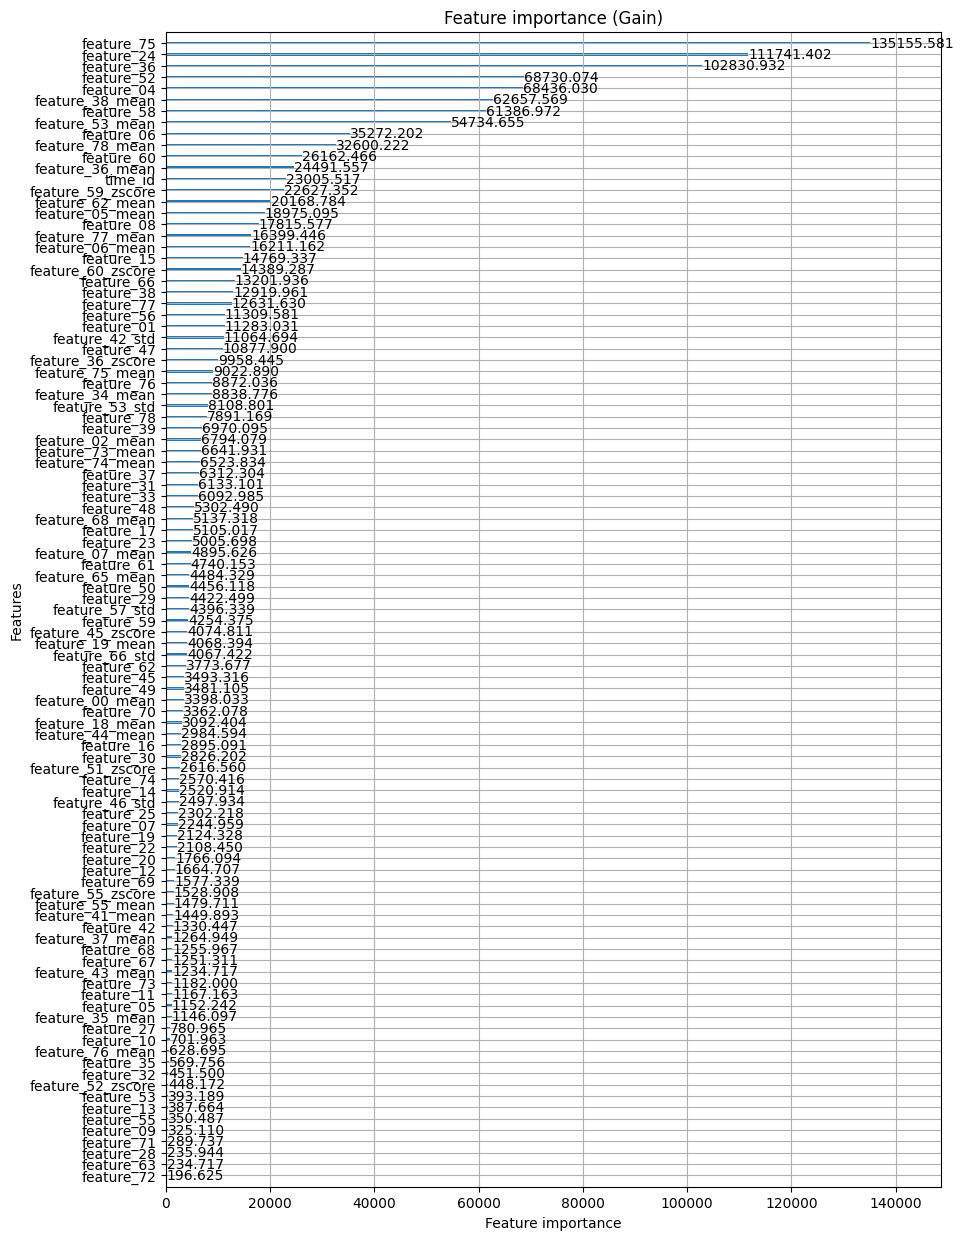

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(10, 15))
plot_importance(model, importance_type='gain', title='Feature importance (Gain)', ax=ax)

# TopK stock features

In [36]:
data_args = {'include_time_id': True}
config = DataConfig(**data_args)
loader = DataLoader(data_dir=DATA_DIR, config=config)
start_dt, end_dt = PARTITIONS_DATE_INFO[8]['min_date'], PARTITIONS_DATE_INFO[9]['max_date']

complete_ds = loader.load(start_dt=start_dt, end_dt=end_dt)
features = loader.features
start_val_date = PARTITIONS_DATE_INFO[9]['min_date']

model = LGBMRegressor(**params)

In [37]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

from prj.utils import wrapper_pbar

def _fn(df: pl.DataFrame, period, responder, schema, top_k) -> pl.DataFrame:
    min_date = df['date_id'].min()
    max_date = df['date_id'].max()
    
    if max_date - min_date != period:
        return pl.DataFrame({}, schema=schema)
    
    # print(min_date, max_date)
    pivot = df.filter(pl.col('date_id') < max_date)\
        .pivot(index=['date_id', 'time_id'], values=[responder], separator='_', on='symbol_id')\
        .fill_nan(None)\
        .fill_null(strategy='zero')
    res = df.select('date_id', 'time_id', 'symbol_id').filter(pl.col('date_id') == max_date)
    
    cols = [col for col in pivot.columns if col not in ['date_id', 'time_id']]
    stocks = np.array([int(col) for col in cols])
    
    corr_matrix = pivot.select(cols).corr().cast(pl.Float32).to_numpy()
    np.fill_diagonal(corr_matrix, -np.inf)
    top_k_indices = np.argsort(-corr_matrix, axis=1)[:, :top_k]
    top_stocks = stocks[top_k_indices]
    stock_topk_mapping = dict(zip(stocks, top_stocks))
    
    # print(stock_topk_mapping)
    curr_stocks = res['symbol_id'].unique().to_numpy()
    res = pl.DataFrame({'date_id': [max_date] * len(curr_stocks), 'symbol_id': curr_stocks})
    res = res.with_columns(
        pl.col('symbol_id').replace_strict(
            stock_topk_mapping,
            default=list(stocks),
            return_dtype=pl.List(pl.Int8)
        ).alias(f'{responder}_top_{top_k}')
    )
    
    return res.cast(schema)


responder = 'responder_6'
top_k = 10
period=7

schema = {'date_id': pl.Int16, 'symbol_id': pl.Int8, f'{responder}_top_{top_k}': pl.List(pl.Int8)}


n_days = complete_ds.select('date_id').collect().n_unique()
with tqdm(total=int(n_days)) as pbar:
    topk_df = complete_ds.select('date_id', 'time_id', 'symbol_id', responder).sort('date_id').group_by_dynamic(
        pl.col('date_id').cast(pl.Int64),
        period=f'{period}i',
        every='1i',
        closed='both',
    ).map_groups(
        wrapper_pbar(
            pbar, 
            lambda df: _fn(df, period=period, responder=responder, schema=schema, top_k=top_k),
        ),
        schema=schema
    ).collect()
    
topk_df

100%|██████████| 339/339 [00:20<00:00, 16.90it/s]


date_id,symbol_id,responder_6_top_10
i16,i8,list[i8]
1367,0,"[7, 1, … 12]"
1367,1,"[0, 16, … 2]"
1367,2,"[30, 5, … 31]"
1367,3,"[19, 22, … 11]"
1367,4,"[38, 14, … 2]"
…,…,…
1698,34,"[10, 36, … 28]"
1698,35,"[33, 0, … 3]"
1698,36,"[10, 6, … 35]"


In [38]:
MEAN_FEATURES = [0, 2, 3, 5, 6, 7, 18, 19, 34, 35, 36, 37, 38, 41, 43, 44, 48, 53, 55, 59, 62, 65, 68, 73, 74, 75, 76, 77, 78]
STD_FEATURES = [39, 42, 46, 53, 57, 66]
SKEW_FEATURES = [5, 40, 41, 42, 43, 44]
ZSCORE_FEATURES = [1, 36, 40, 45, 48, 49, 51, 52, 53, 54, 55, 59, 60]
base_features = [f'feature_{j:02d}' for j in range(79)]
_complete_ds = complete_ds.select('date_id', 'time_id', 'symbol_id', *base_features)
batch_size = 1000
final = pl.concat([
    batch.explode(f'{responder}_top_{top_k}').join(
        _complete_ds.filter(pl.col('date_id').is_in(batch['date_id'].unique())).collect(),
        left_on=['date_id', f'{responder}_top_{top_k}'], right_on=['date_id', 'symbol_id']
    ).select('date_id', 'time_id', 'symbol_id', f'{responder}_top_{top_k}', *base_features) \
    .group_by('date_id', 'time_id', 'symbol_id')\
    .agg(
        pl.col([f'feature_{j:02d}' for j in set(MEAN_FEATURES + ZSCORE_FEATURES)]).mean().name.suffix(f'_{responder}_mean'),
        pl.col([f'feature_{j:02d}' for j in set(STD_FEATURES + ZSCORE_FEATURES)]).std().name.suffix(f'_{responder}_std'),
        pl.col([f'feature_{j:02d}' for j in SKEW_FEATURES]).skew().name.suffix(f'_{responder}_skew'),
    )
    for batch in tqdm(topk_df.iter_slices(n_rows=batch_size), total=int(len(topk_df) / batch_size))
])

final

13it [02:27, 11.36s/it]                        


date_id,time_id,symbol_id,feature_00_responder_6_mean,feature_01_responder_6_mean,feature_02_responder_6_mean,feature_03_responder_6_mean,feature_05_responder_6_mean,feature_06_responder_6_mean,feature_07_responder_6_mean,feature_18_responder_6_mean,feature_19_responder_6_mean,feature_34_responder_6_mean,feature_35_responder_6_mean,feature_36_responder_6_mean,feature_37_responder_6_mean,feature_38_responder_6_mean,feature_40_responder_6_mean,feature_41_responder_6_mean,feature_43_responder_6_mean,feature_44_responder_6_mean,feature_45_responder_6_mean,feature_48_responder_6_mean,feature_49_responder_6_mean,feature_51_responder_6_mean,feature_52_responder_6_mean,feature_53_responder_6_mean,feature_54_responder_6_mean,feature_55_responder_6_mean,feature_59_responder_6_mean,feature_60_responder_6_mean,feature_62_responder_6_mean,feature_65_responder_6_mean,feature_68_responder_6_mean,feature_73_responder_6_mean,feature_74_responder_6_mean,feature_75_responder_6_mean,feature_76_responder_6_mean,feature_77_responder_6_mean,feature_78_responder_6_mean,feature_01_responder_6_std,feature_66_responder_6_std,feature_36_responder_6_std,feature_39_responder_6_std,feature_40_responder_6_std,feature_42_responder_6_std,feature_45_responder_6_std,feature_46_responder_6_std,feature_48_responder_6_std,feature_49_responder_6_std,feature_51_responder_6_std,feature_52_responder_6_std,feature_53_responder_6_std,feature_54_responder_6_std,feature_55_responder_6_std,feature_57_responder_6_std,feature_59_responder_6_std,feature_60_responder_6_std,feature_05_responder_6_skew,feature_40_responder_6_skew,feature_41_responder_6_skew,feature_42_responder_6_skew,feature_43_responder_6_skew,feature_44_responder_6_skew
i16,i16,i8,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f64,f64,f64,f64,f64,f64
1370,11,12,1.983454,2.331173,1.238135,1.693755,-0.616624,0.36114,1.24951,-1.271554,-1.420702,1.974337,2.523184,2.2013,0.164055,0.479564,0.329135,null,-0.61226,null,-0.82678,-0.192253,0.663362,-0.183351,null,null,-0.687081,null,-0.580477,-0.67983,-0.343916,-1.26529,1.255537,-0.020481,-0.105969,0.06823,0.013986,0.05783,0.000985,0.183497,0.373243,0.527075,null,0.285418,null,0.4485,0.358256,0.59243,0.90591,0.940659,null,null,0.924389,null,0.686301,0.977914,1.298207,0.322096,-0.790704,null,null,-0.322118,null
1373,898,26,0.186834,-1.157767,0.279662,0.294558,-2.927264,-0.043639,-1.285582,-0.107545,1.390072,0.623722,0.783971,-0.330861,-0.264393,-0.024809,0.197632,-0.048872,-0.086472,-0.342879,0.563532,-0.107504,-0.505758,0.035301,-0.090787,-0.846089,-0.125727,0.006108,0.018429,-0.465655,-0.348743,-0.26137,-0.111583,0.035571,0.01229,-0.089644,-0.092104,-0.061771,-0.059577,0.357822,0.286875,0.561657,0.394776,0.504812,0.531581,0.89041,0.643629,0.34968,0.433275,0.498402,0.85751,0.764882,0.502395,0.619496,0.684683,0.395951,0.37952,0.357007,0.795271,0.053518,-0.810874,0.050982,-0.309332
1367,757,6,1.31079,0.174264,1.188197,1.495016,-0.910866,-0.157807,-1.380842,1.045655,-0.476839,2.399919,2.336359,-0.272484,1.079334,1.260192,-0.148773,-0.353104,0.253477,-0.092976,-0.534846,-0.100887,-0.305211,-0.265535,-0.563414,-0.109963,0.274485,0.317171,-0.0762,-0.376298,-0.334632,0.87125,-0.200123,-0.032574,-0.112291,0.144491,-0.041009,0.097591,-0.025958,0.254286,1.148723,0.718854,0.448799,0.433708,0.895274,0.968357,0.854458,0.203725,0.252213,0.504175,0.373206,0.774983,0.526599,0.827064,0.933055,0.401479,0.36804,-0.290989,-0.05673,-0.210801,-0.12427,-0.117533,0.030697
1387,490,22,3.05939,0.470084,3.173398,3.244835,0.985007,4.703597,4.331357,-0.179572,0.354695,2.909738,2.683861,0.282396,-0.617054,-0.130096,0.952202,1.379115,-0.338145,0.194262,1.136901,1.794697,1.334953,1.081128,1.617142,0.789345,0.303812,0.835517,1.622124,1.623694,-0.320694,-0.525418,0.049752,0.881695,0.826284,1.076011,1.160725,0.832995,0.973995,0.314059

In [39]:
df = complete_ds.join(final.lazy(), on=['date_id', 'time_id', 'symbol_id'], how='left')\
    .with_columns(
        pl.col(f'feature_{j:02d}').sub(f'feature_{j:02d}_{responder}_mean').truediv(f'feature_{j:02d}_{responder}_std').name.suffix(f'_{responder}_zscore') for j in ZSCORE_FEATURES
    ).drop([f'feature_{j:02d}_{responder}_std' for j in ZSCORE_FEATURES if j not in STD_FEATURES] + \
        [f'feature_{j:02d}_{responder}_mean' for j in ZSCORE_FEATURES if j not in MEAN_FEATURES]
    )

In [40]:
train_ds = df.filter(pl.col('date_id') < start_val_date)
val_ds = df.filter(pl.col('date_id') >= start_val_date)

curr_features =  features +  [f'feature_{j:02d}_{responder}_mean' for j in MEAN_FEATURES] + \
        [f'feature_{j:02d}_{responder}_std' for j in STD_FEATURES] + [f'feature_{j:02d}_{responder}_skew' for j in SKEW_FEATURES] + \
        [f'feature_{j:02d}_{responder}_zscore' for j in ZSCORE_FEATURES] 
        
X_train, y_train, w_train = build_splits(train_ds, features=curr_features)
X_val, y_val, w_val = build_splits(val_ds, features=curr_features)

evaluate_model(model, X_train, y_train, X_val, y_val, w_val, curr_features)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 2.978743 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 33379
[LightGBM] [Info] Number of data points in the train set: 6140024, number of used features: 134
[LightGBM] [Info] Start training from score 0.001341


0.005805643733772015

<Axes: title={'center': 'Feature importance (Gain)'}, xlabel='Feature importance', ylabel='Features'>

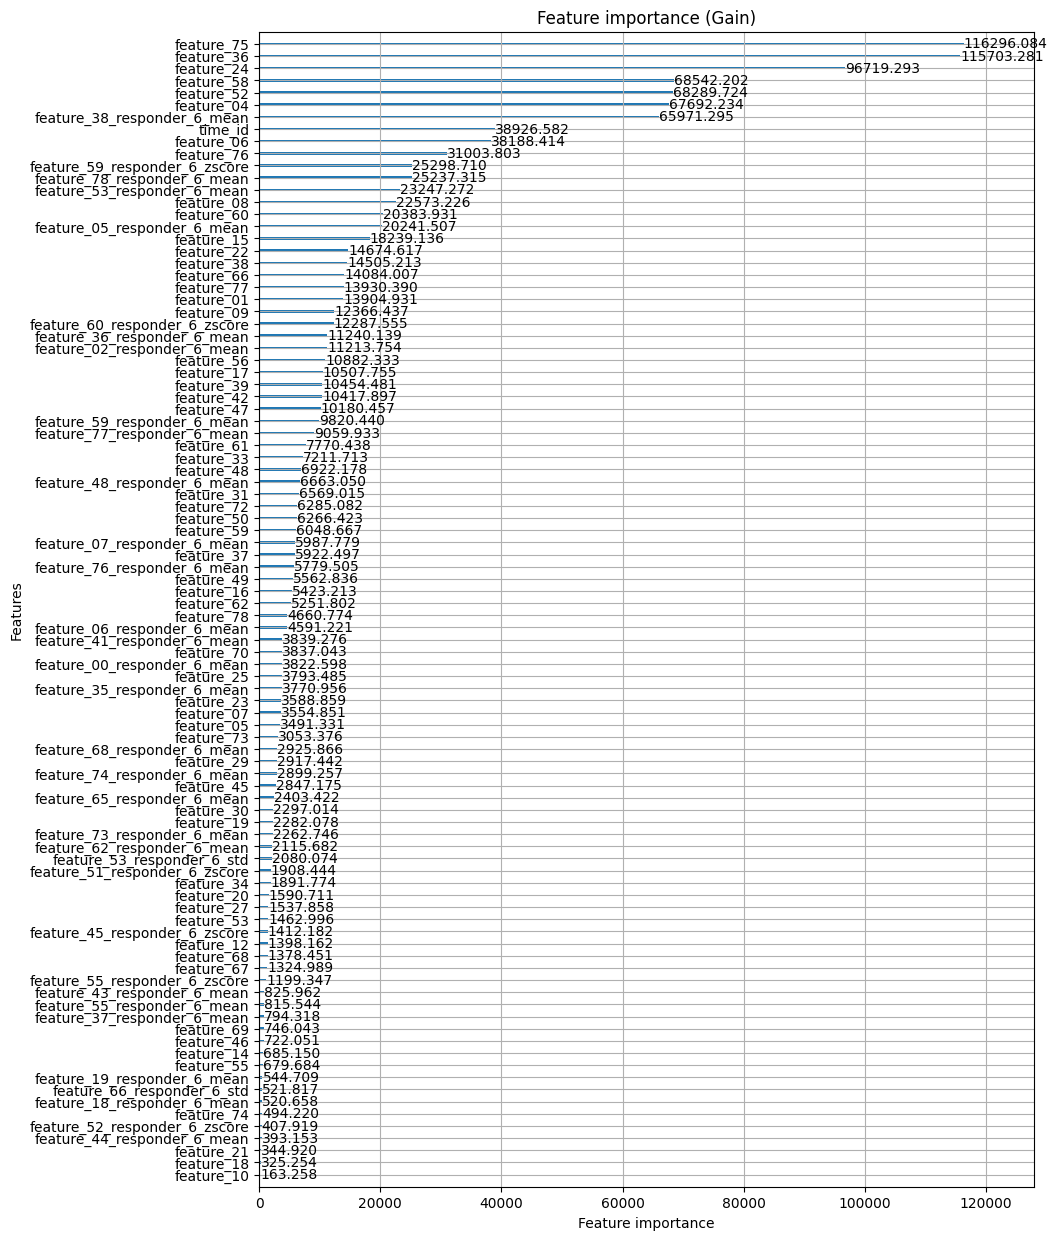

In [41]:
fig, ax = plt.subplots(1, 1, figsize=(10, 15))
plot_importance(model, importance_type='gain', title='Feature importance (Gain)', ax=ax)

# Group correlation features

In [14]:
data_args = {'include_time_id': True}
config = DataConfig(**data_args)
loader = DataLoader(data_dir=DATA_DIR, config=config)
start_dt, end_dt = PARTITIONS_DATE_INFO[8]['min_date'], PARTITIONS_DATE_INFO[9]['max_date']

complete_ds = loader.load(start_dt=start_dt, end_dt=end_dt)
features = loader.features
start_val_date = PARTITIONS_DATE_INFO[9]['min_date']

model = LGBMRegressor(**params)

In [15]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

from prj.utils import wrapper_pbar

def _fn(df: pl.DataFrame, period, responders, schema) -> pl.DataFrame:
    min_date = df['date_id'].min()
    max_date = df['date_id'].max()
    
    if max_date - min_date != period:
        return pl.DataFrame({}, schema=schema)
    
    # print(min_date, max_date)
    pivot = df.filter(pl.col('date_id') < max_date)\
        .pivot(index=['date_id', 'time_id'], values=responders, separator='_', on='symbol_id')\
        .fill_nan(None)\
        .fill_null(strategy='zero')
        
    res = df.select('date_id', 'time_id', 'symbol_id').filter(pl.col('date_id') == max_date)
    
    def auto_select_t(linked):
        """Automatically select t using the Elbow Method"""
        distances = linked[:, 2]  # Extract the distances from the linkage matrix
        diff = np.diff(distances[::-1])  # Reverse distances and compute the derivative
        elbow_index = np.argmax(diff) + 1  # Find the largest jump in distances
        return distances[::-1][elbow_index]
    
    
    
    for responder in responders:
        cols = [col for col in pivot.columns if col not in ['date_id', 'time_id']]
        stocks = [int(col) for col in cols]
        
        df_corr_responder = pivot.select(cols).corr()
        linked = linkage(df_corr_responder, method='ward')
        t = auto_select_t(linked)
        # print(f'Max date: {max_date}, responder: {responder}, t: {t}')
        cluster_labels = fcluster(linked, t=t, criterion='distance')
    
        res = res.with_columns(
            pl.col('symbol_id').replace_strict(old=stocks, new=cluster_labels, default=-1, return_dtype=pl.Int8).alias(f'cluster_label_{responder}')
        )
        
    return res.cast(schema)


# responders = [f'responder_{i}' for i in range(1, 9)]
responders = ['responder_6']
schema = {'date_id': pl.Int16, 'time_id': pl.Int16, 'symbol_id': pl.Int8}
for responder in responders:
    schema[f'cluster_label_{responder}'] = pl.Int8
    
period=7

n_days = complete_ds.select('date_id').collect().n_unique()
with tqdm(total=int(n_days)) as pbar:
    clusters = complete_ds.select('date_id', 'time_id', 'symbol_id', *responders).sort('date_id').group_by_dynamic(
        pl.col('date_id').cast(pl.Int64),
        period=f'{period}i',
        every='1i',
        closed='both',
    ).map_groups(
        wrapper_pbar(
            pbar, 
            lambda df: _fn(df, period=period, responders=responders, schema=schema),
        ),
        schema=schema
    ).collect()
    
clusters

100%|██████████| 339/339 [00:20<00:00, 16.73it/s]


date_id,time_id,symbol_id,cluster_label_responder_6
i16,i16,i8,i8
1367,0,0,2
1367,0,1,2
1367,0,2,13
1367,0,3,4
1367,0,4,29
…,…,…,…
1698,967,34,33
1698,967,35,6
1698,967,36,26


In [16]:
cluster_label_cols = [f'cluster_label_responder_6']

df = complete_ds.join(
    clusters.lazy(), on=['date_id', 'time_id', 'symbol_id'], how='left'
).with_columns(
    pl.col(cluster_label_cols).fill_null(-1)
)

In [17]:
MEAN_FEATURES = [0, 2, 3, 5, 6, 7, 18, 19, 34, 35, 36, 37, 38, 41, 43, 44, 48, 53, 55, 59, 62, 65, 68, 73, 74, 75, 76, 77, 78]
STD_FEATURES = [39, 42, 46, 53, 57, 66]
SKEW_FEATURES = [5, 40, 41, 42, 43, 44]
ZSCORE_FEATURES = [1, 36, 40, 45, 48, 49, 51, 52, 53, 54, 55, 59, 60]
def _include_intrastock_norm(df: pl.LazyFrame, responder) -> pl.LazyFrame:
    df = df.with_columns(
        pl.col([f'feature_{j:02d}' for j in set(MEAN_FEATURES + ZSCORE_FEATURES)]).mean().over(['date_id', 'time_id', f'cluster_label_{responder}']).name.suffix(f'_{responder}_mean'),
        pl.col([f'feature_{j:02d}' for j in set(STD_FEATURES + ZSCORE_FEATURES)]).std().over(['date_id', 'time_id', f'cluster_label_{responder}']).name.suffix(f'_{responder}_std'),
        pl.col([f'feature_{j:02d}' for j in SKEW_FEATURES]).skew().over(['date_id', 'time_id', f'cluster_label_{responder}']).name.suffix(f'_{responder}_skew'),
    ).with_columns(
        pl.col(f'feature_{j:02d}').sub(f'feature_{j:02d}_{responder}_mean').truediv(f'feature_{j:02d}_{responder}_std').name.suffix(f'_{responder}_zscore') for j in ZSCORE_FEATURES
    ).drop([f'feature_{j:02d}_{responder}_std' for j in ZSCORE_FEATURES if j not in STD_FEATURES] + \
        [f'feature_{j:02d}_{responder}_mean' for j in ZSCORE_FEATURES if j not in MEAN_FEATURES])
    
    return df

df = _include_intrastock_norm(df, 'responder_6')

df = df.drop(cluster_label_cols)

In [18]:
train_ds = df.filter(pl.col('date_id') < start_val_date)
val_ds = df.filter(pl.col('date_id') >= start_val_date)

curr_features =  features +  [f'feature_{j:02d}_{responder}_mean' for j in MEAN_FEATURES] + \
        [f'feature_{j:02d}_{responder}_std' for j in STD_FEATURES] + [f'feature_{j:02d}_{responder}_skew' for j in SKEW_FEATURES] + \
        [f'feature_{j:02d}_{responder}_zscore' for j in ZSCORE_FEATURES] 
    
print(curr_features)
        
X_train, y_train, w_train = build_splits(train_ds, features=curr_features)
X_val, y_val, w_val = build_splits(val_ds, features=curr_features)

evaluate_model(model, X_train, y_train, X_val, y_val, w_val, curr_features)

['feature_00', 'feature_01', 'feature_02', 'feature_03', 'feature_04', 'feature_05', 'feature_06', 'feature_07', 'feature_08', 'feature_09', 'feature_10', 'feature_11', 'feature_12', 'feature_13', 'feature_14', 'feature_15', 'feature_16', 'feature_17', 'feature_18', 'feature_19', 'feature_20', 'feature_21', 'feature_22', 'feature_23', 'feature_24', 'feature_25', 'feature_26', 'feature_27', 'feature_28', 'feature_29', 'feature_30', 'feature_31', 'feature_32', 'feature_33', 'feature_34', 'feature_35', 'feature_36', 'feature_37', 'feature_38', 'feature_39', 'feature_40', 'feature_41', 'feature_42', 'feature_43', 'feature_44', 'feature_45', 'feature_46', 'feature_47', 'feature_48', 'feature_49', 'feature_50', 'feature_51', 'feature_52', 'feature_53', 'feature_54', 'feature_55', 'feature_56', 'feature_57', 'feature_58', 'feature_59', 'feature_60', 'feature_61', 'feature_62', 'feature_63', 'feature_64', 'feature_65', 'feature_66', 'feature_67', 'feature_68', 'feature_69', 'feature_70', 'feat

0.005680549250976608

<Axes: title={'center': 'Feature importance (Gain)'}, xlabel='Feature importance', ylabel='Features'>

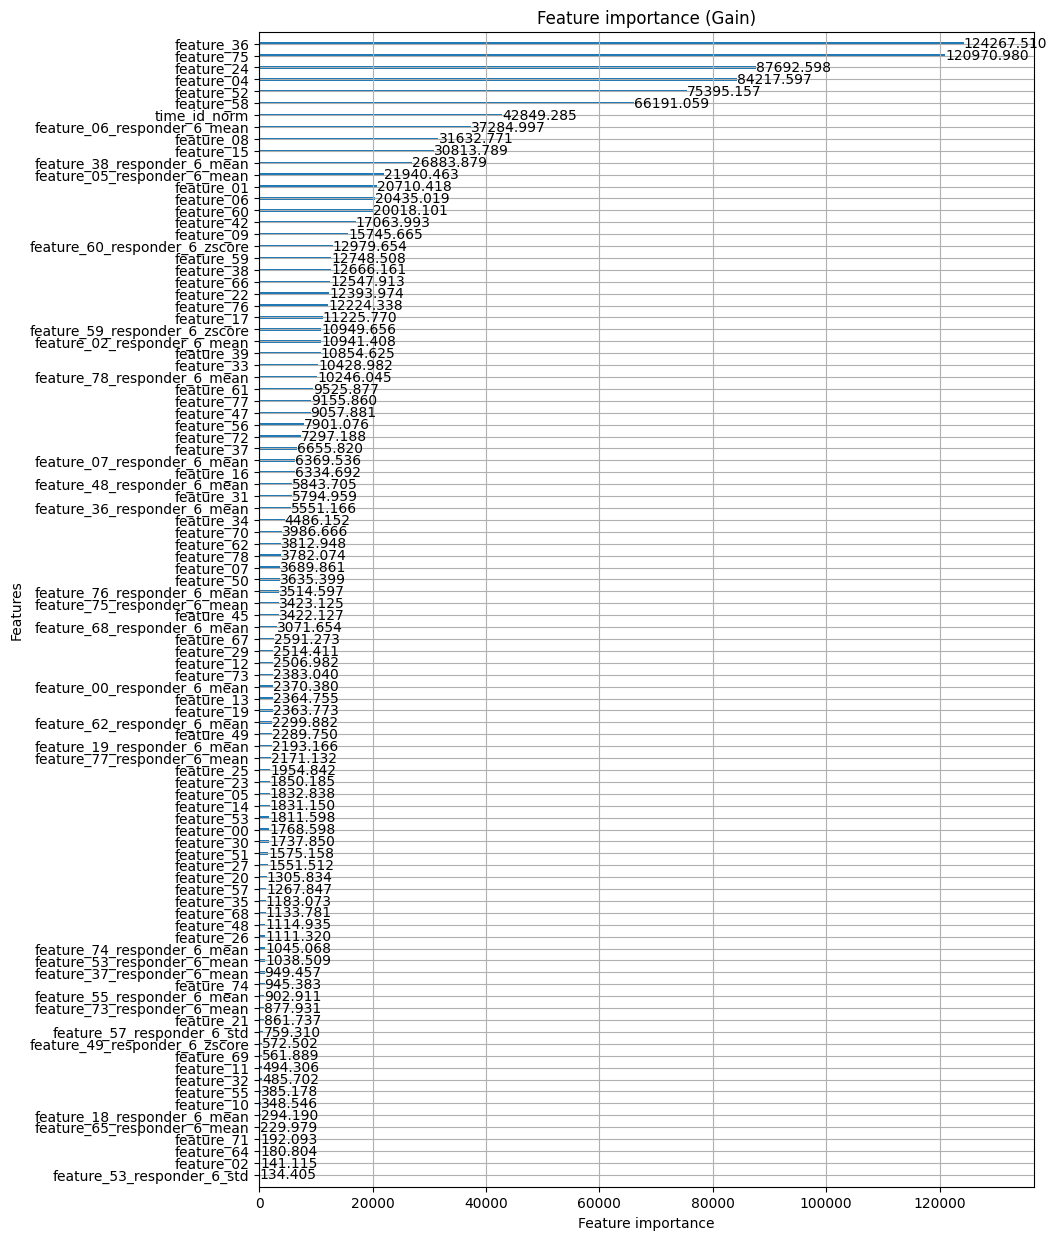

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(10, 15))
plot_importance(model, importance_type='gain', title='Feature importance (Gain)', ax=ax)

In [17]:
class BlockingTimeSeriesSplit():
    def __init__(self, n_splits):
        self.n_splits = n_splits
    
    def get_n_splits(self, groups):
        return self.n_splits
    
    def split(self, X, y=None, groups=None):
        n_samples = len(X)
        k_fold_size = n_samples // self.n_splits
        indices = np.arange(n_samples)
    
        margin = 0
        for i in range(self.n_splits):
            start = i * k_fold_size
            stop = start + k_fold_size
            mid = int(0.8 * (stop - start)) + start
            yield indices[start: mid], indices[mid + margin: stop]



In [32]:
from prj.utils import CombinatorialPurgedKFold


sp = CombinatorialPurgedKFold(n_splits=0)
arr = np.random.rand(9, 2)

for x, y in sp.split(X=arr):
    print(x, y)

ZeroDivisionError: integer division or modulo by zero

In [18]:
import numpy as np
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn.model_selection import TimeSeriesSplit

X = np.zeros((100, 30))
y = np.ones(100)

In [19]:
kf = BlockingTimeSeriesSplit(n_splits=5)
for train_index, test_index in kf.split(X, y):
    print("TRAIN:", train_index, "TEST:", test_index)

TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15] TEST: [16 17 18 19]
TRAIN: [20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35] TEST: [36 37 38 39]
TRAIN: [40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55] TEST: [56 57 58 59]
TRAIN: [60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75] TEST: [76 77 78 79]
TRAIN: [80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95] TEST: [96 97 98 99]


In [15]:
train_index, test_index

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 array([20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35]))